In [6]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import numpy as np
import tqdm
import torch
import jax
import jax.numpy as jnp
import networkx as nx
import matplotlib.pyplot as plt
from dgl import AddReverse

from ott import utils
from ott.math import utils as mu
from ott.geometry import geometry, pointcloud
from ott.geometry.graph import Graph
from ott.solvers.linear import sinkhorn, sinkhorn_lr
from ott.problems.linear import linear_problem
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein
import tqdm

ModuleNotFoundError: No module named 'jax'

## OT for GNN Fusion

In [ ]:
# GPU setup

### Sample Data

In [20]:
# Prepare a possible input for OT problem
import random 

# Create as many graphs as there are data points for generating activations
n_data_graphs = 4
data_graphs = []
X_size = 5 # Corresponds to numbers of rows in convolution weight matrix of source model
Y_size = 5 # Corresponds to numbers of rows in convolution weight matrix of target model
X = [] # Activations for source
Y = [] # Activations for target
a = torch.ones(X_size)/X_size
b = torch.ones(Y_size)/Y_size

for i in range(n_data_graphs):
    num_nodes = random.randint(5,10)
    edge_indices_1 = [j for j in range(num_nodes)]
    edge_indices_2 = [random.randint(0,num_nodes-1) for j in range(num_nodes)]
    graph = dgl.graph((edge_indices_1, edge_indices_2), num_nodes=num_nodes)
    data_graphs.append(graph)

for i in range(X_size):
    x = []
    for graph in data_graphs:
        graph_X = graph.clone()
        num_nodes = graph_X.num_nodes()
        #graph_X.ndata["Feature"] = torch.randn(num_nodes,1)
        graph_X.ndata["Feature"] = torch.ones(num_nodes,1)*i
        #graph_X.ndata["Feature"] = torch.linspace(0,1,num_nodes)
        x.append(graph_X)
    X.append(x)

for i in range(Y_size):
    y = []
    for graph in data_graphs:
        graph_Y = graph.clone()
        num_nodes = graph_Y.num_nodes()
        #graph_Y.ndata["Feature"] = torch.randn(num_nodes,1)
        graph_Y.ndata["Feature"] = torch.ones(num_nodes,1)*i*1.2
        #graph_Y.ndata["Feature"] = torch.linspace(0,1,num_nodes)
        y.append(graph_Y)
    Y.append(y)


In [11]:
def _graph_metric_QE(graph_x, graph_y, alpha):
    # Get features
    x_features = graph_x.ndata["Feature"]
    y_features = graph_y.ndata["Feature"]

    # Get number of edges (here graph structure of x and y are assumed to be the same)
    num_edges = graph_x.num_edges()
    assert num_edges == graph_y.num_edges()
    num_nodes = graph_x.num_nodes()
    assert num_nodes == graph_y.num_nodes()

    # Compute energy functional
    edge_energy = 0
    node_energy = 0

    # Compute edge energy
    for i in range(num_edges):
        # Get indeces of connected nodes
        out_node = graph_x.edges()[0][i]
        in_node = graph_x.edges()[1][i]

        # Get features of connected nodes of graphs x and y
        x_out_feature = x_features[out_node]
        y_in_feature = y_features[in_node]

        # Compute cost
        edge_energy += (x_out_feature - y_in_feature)**2 

    # Compute node energy
    for i in range(num_nodes):
        # Get feature of node
        x_feature = x_features[i]
        y_feature = y_features[i]

        # Compute cost
        node_energy += (x_feature - y_feature)**2

    # Compute weighted total energy
    total_energy = alpha*edge_energy + (1-alpha)*node_energy

    return total_energy
        

### Setup Cost Matrix

#### Metrics Between Pairs of Graphs

In [12]:
def _graph_metric_GW(graph_x, graph_y, loss='sqeucl', output_cost='primal', fused_penalty=1.0, epsilon=100, tau_a=1.0, tau_b=1.0, max_iterations=20, directed=False, normalize=True):
    """
    Compute GW cost between two sets of dgl graphs
    x, y are sets of dgl graphs
    """
    # Extract features
    x_features = graph_x.ndata["Feature"]
    y_features = graph_y.ndata["Feature"]

    # Extract adjacency matrices
    adj_mat_x = graph_x.adjacency_matrix().to_dense()
    adj_mat_y = graph_y.adjacency_matrix().to_dense()

    # Create geometries
    geom_xy = pointcloud.PointCloud(jnp.array(x_features), jnp.array(y_features), cost_fn=None)
    geom_xx = Graph.from_graph(jnp.array(adj_mat_x), directed=directed, normalize=normalize)
    geom_yy = Graph.from_graph(jnp.array(adj_mat_y), directed=directed, normalize=normalize)

    # Create quadratic problem
    prob = quadratic_problem.QuadraticProblem(geom_xx, geom_yy, geom_xy, 
                                            loss=loss,
                                            fused_penalty=fused_penalty,
                                            tau_a=tau_a, tau_b=tau_b,
                                            ranks=-1)
    
    # Instantiate a jitt'ed Gromov-Wasserstein solver
    solver = jax.jit(
        gromov_wasserstein.GromovWasserstein(
            epsilon=epsilon, max_iterations=max_iterations, store_inner_errors=True
        )
    )   

    # Solve the problem
    ot = solver(prob)

    # Extract costs
    if output_cost == 'primal':
        primal_cost = ot.primal_cost
        return primal_cost
    elif output_cost == 'reg_gw':
        reg_gw_cost = ot.reg_gw_cost
        return reg_gw_cost

def _graph_metric_QE(graph_x, graph_y, alpha):
    # Get features
    x_features = graph_x.ndata["Feature"]
    y_features = graph_y.ndata["Feature"]

    # Get number of edges (here graph structure of x and y are assumed to be the same)
    num_edges = graph_x.num_edges()
    assert num_edges == graph_y.num_edges()
    num_nodes = graph_x.num_nodes()
    assert num_nodes == graph_y.num_nodes()

    # Compute energy functional
    edge_energy = 0
    node_energy = 0

    # Compute edge energy
    for i in range(num_edges):
        # Get indices of connected nodes
        out_node = graph_x.edges()[0][i]
        in_node = graph_x.edges()[1][i]

        # Get features of connected nodes of graphs x and y
        x_out_feature = x_features[out_node]
        y_in_feature = y_features[in_node]

        # Compute cost
        edge_energy += (x_out_feature - y_in_feature)**2 

    # Compute node energy
    for i in range(num_nodes):
        # Get feature of node
        x_feature = x_features[i]
        y_feature = y_features[i]

        # Compute cost
        node_energy += (x_feature - y_feature)**2

    # Compute weighted total energy
    total_energy = alpha*edge_energy + (1-alpha)*node_energy

    return total_energy


#### Metrics For Geometry of OT Problem

In [13]:
def _cost_fn_l2_GW(x, y, graph_metric):
    """
    Cost function for GW-metric based OT problem
    x, y are sets of dgl graphs - i.e. the GNN activations
    """
    # Compute pairwise costs
    cost = 0
    num_graphs = len(x)
    assert num_graphs == len(y)

    for i in range(num_graphs):
        cost += graph_metric(x[i], y[i])
    return cost

def _cost_fn_l2_QE(x, y, graph_metric, alpha):
    """
    Cost function for QE-metric (quadratic energy) based OT problem
    x, y are sets of dgl graphs - i.e. the GNN activations
    """
    # Compute pairwise costs
    cost = 0
    num_graphs = len(x)
    assert num_graphs == len(y)

    for i in range(num_graphs):
        cost += graph_metric(x[i], y[i], alpha)
    return cost

def _cost_fn_l2(x, y):
    """
    Cost function for l2-metric based OT problem
    x, y are sets of dgl graphs - i.e. the GNN activations
    """
    n = len(x)
    assert n == len(y)
    cost = 0
    for i in range(n):
        cost += mu.norm(jnp.array(x[i].ndata["Feature"]) - jnp.array(y[i].ndata["Feature"]))
    return cost

def _get_ot_cost_matrix(X, Y, cost_fn):
    """
    X: lists of lists of dgl graphs
    Y: lists of lists of dgl graphs
    """
    cost_matrix = np.zeros((len(X),len(Y)))
    for i in tqdm.tqdm(range(len(X))):
        for j in range(len(Y)):
            cost_matrix[i][j] = cost_fn(X[i], Y[j])
    return jnp.array(cost_matrix)



#### Solving OT Problem

In [14]:
def _get_current_transport_map(a, b, X, Y, cost_fn, epsilon = None, tau_a = 1, tau_b = 1, low_rank = False, verbose = False):
    """
    Solve optimal transport problem for activation support for GNN Fusion
    """
    # Define Geometry
    cost_matrix = _get_ot_cost_matrix(X, Y, cost_fn)
    geom = geometry.Geometry(cost_matrix=cost_matrix, epsilon=epsilon) 

    # Define Problem
    ot_prob = linear_problem.LinearProblem(geom, tau_a=tau_a, tau_b=tau_b)

    # Solve Problem       
    with tqdm.tqdm() as pbar:
        progress_fn = utils.tqdm_progress_fn(pbar)

        if low_rank == True:
            solve_fn = sinkhorn_lr.LRSinkhorn(rank=int(min(len(x), len(y)) / 2), progress_fn=progress_fn)
        else:
            solve_fn = sinkhorn.Sinkhorn(progress_fn=progress_fn)
            
        ot = jax.jit(solve_fn)(ot_prob)

    if verbose:
        print(
        "\nSinkhorn has converged: ",
        ot.converged,
        "\n",
        "-Error upon last iteration: ",
        ot.errors[(ot.errors > -1)][-1],
        "\n",
        "-Sinkhorn required ",
        jnp.sum(ot.errors > -1),
        " iterations to converge. \n",
        "-Entropy regularized OT cost: ",
        ot.reg_ot_cost,
        "\n",
        "-OT cost (without entropy): ",
        jnp.sum(ot.matrix * ot.geom.cost_matrix),
        )

    return ot

#### Applying OT with Different Metrics

 20%|██        | 41/200 [00:00<00:02, 56.07it/s, error: 9.870529e-04]


Sinkhorn has converged:  True 
 -Error upon last iteration:  0.0009870529 
 -Sinkhorn required  41  iterations to converge. 
 -Entropy regularized OT cost:  4.5326858 
 -OT cost (without entropy):  4.5143743


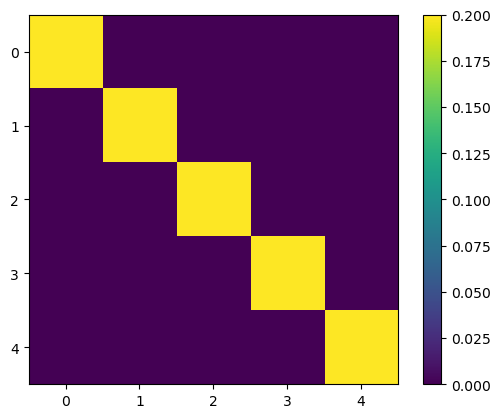

In [16]:
# EUCLEDEAN GEOMETRY - NO GRAPH INFORMATION
ot = _get_current_transport_map(a, b, X, Y, cost_fn = _cost_fn_l2, epsilon=0.01, verbose=True)
plt.imshow(ot.matrix)
plt.colorbar()

 20%|██        | 41/200 [00:00<00:02, 58.72it/s, error: 9.807795e-04]


Sinkhorn has converged:  True 
 -Error upon last iteration:  0.0009807795 
 -Sinkhorn required  41  iterations to converge. 
 -Entropy regularized OT cost:  1.1307063 
 -OT cost (without entropy):  0.9689211


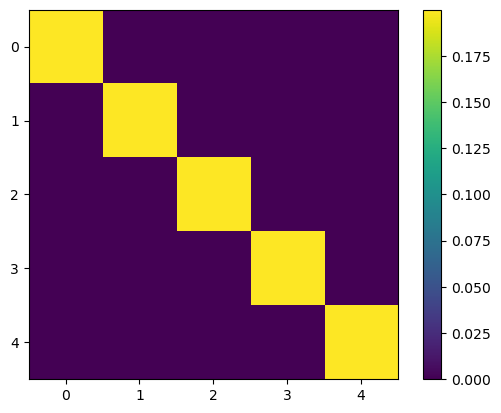

In [19]:
# GW DISTANCE GEOEMTRY - GRAPH INFORMATION
cost_GW = lambda x, y: _cost_fn_l2_GW(x, y, _graph_metric_GW)
ot = _get_current_transport_map(a, b, X, Y, cost_fn = cost_GW, epsilon=0.1, verbose=True)
plt.imshow(ot.matrix)
plt.colorbar()

 26%|██▌       | 51/200 [00:00<00:02, 72.71it/s, error: 8.819252e-04]


Sinkhorn has converged:  True 
 -Error upon last iteration:  0.0008819252 
 -Sinkhorn required  51  iterations to converge. 
 -Entropy regularized OT cost:  7.6816125 
 -OT cost (without entropy):  7.6742334


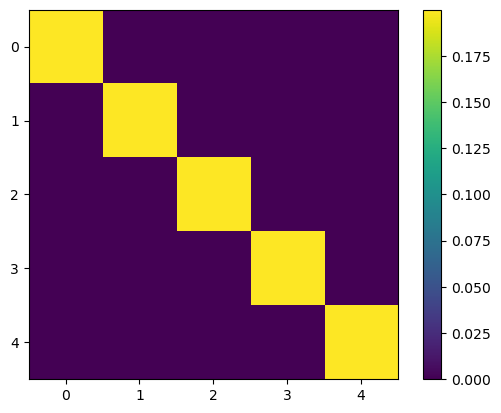

In [18]:
# QE Quadratic Energy GEOEMTRY - GRAPH INFORMATION
alpha = 0.5
cost_QE = lambda x, y: _cost_fn_l2_QE(x, y, _graph_metric_QE, alpha)
ot = _get_current_transport_map(a, b, X, Y, cost_fn = cost_QE, epsilon=0.001, verbose=True)
plt.imshow(ot.matrix)
plt.colorbar()

## DGL Graph Objects

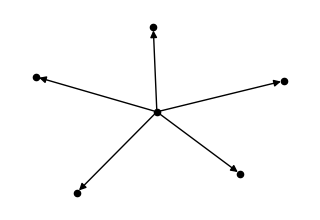

In [24]:
# Create dgl graph
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=6)
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}

# Assign a 3-dimensional node feature vector for each node.
g.ndata["x"] = torch.randn(6, 3)
g.ndata["x"][0] = torch.tensor([1, 2, 0])

# Plot graph
G = dgl.to_networkx(g)
plt.figure(figsize=[3,2])
nx.draw(G, **options)

In [59]:
transform = AddReverse()
g_undirected = transform(g)

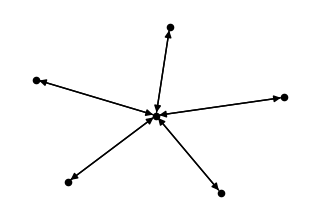

In [61]:
# Plot graph
G = dgl.to_networkx(g_undirected)
plt.figure(figsize=[3,2])
nx.draw(G, **options)